# Machine Learning Project Report

# 1. Environment & Dateset preparation

In [ ]:
!pip install itables

## 1.1 Import libraries

In [242]:
import numpy as np
import pandas as pd
import dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from itables import show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from itables import show

In [235]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip -qq -o "pima-indians-diabetes-database.zip" -d "dataset"
!echo "Unzip completed"

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
pima-indians-diabetes-database.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzip completed


## 1.2 Dataset Visualization

In [236]:
df = pd.read_csv('dataset/diabetes.csv')
class_names = df['Outcome'].unique()
target = 'Outcome'

In [237]:
# Display the first 5 rows of the dataset
show(df.head())

In [238]:
# Display dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [243]:
with pd.option_context("display.float_format", '{:.1}'.format):
    # Basic statistics of the dataset
    show(df.describe())

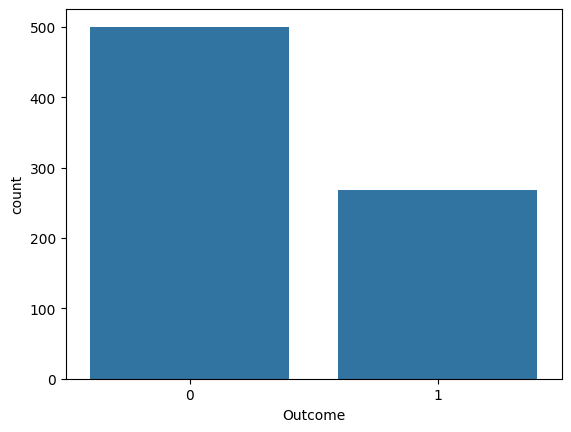

In [216]:
# sns.pairplot(df, hue="Outcome")
# plt.show()

#bar chart by outcome
sns.countplot(data=df, x=target)
plt.show()

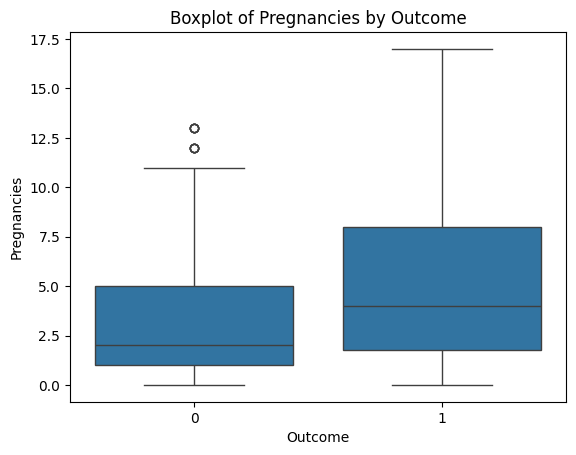

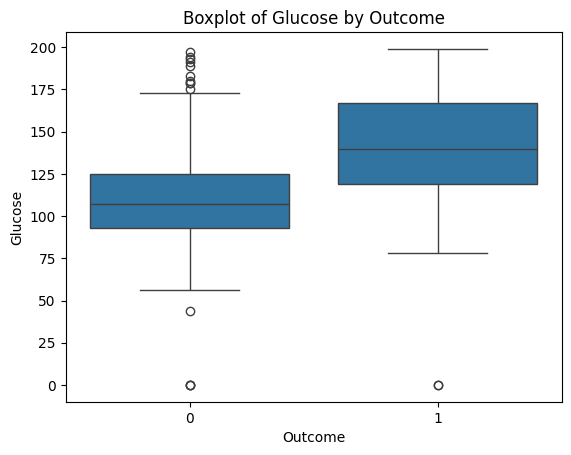

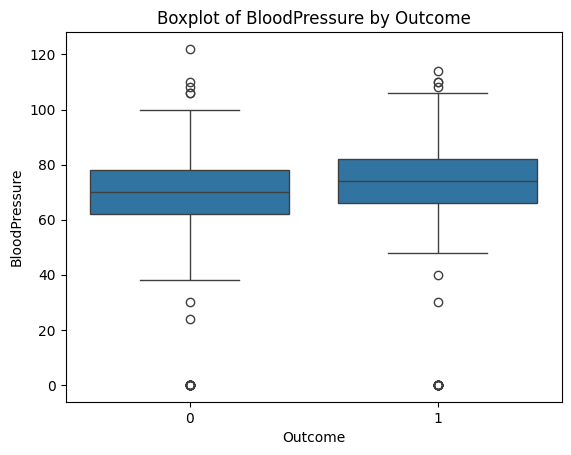

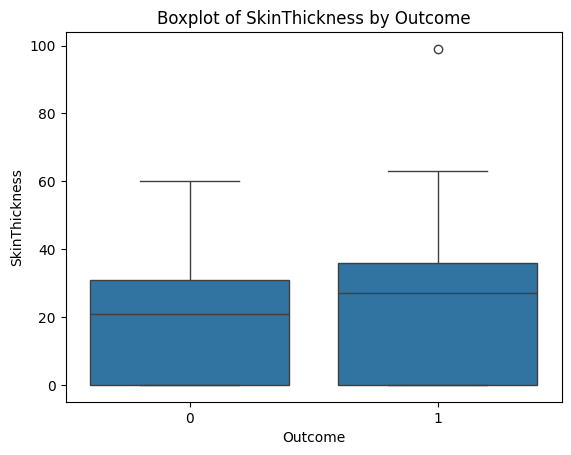

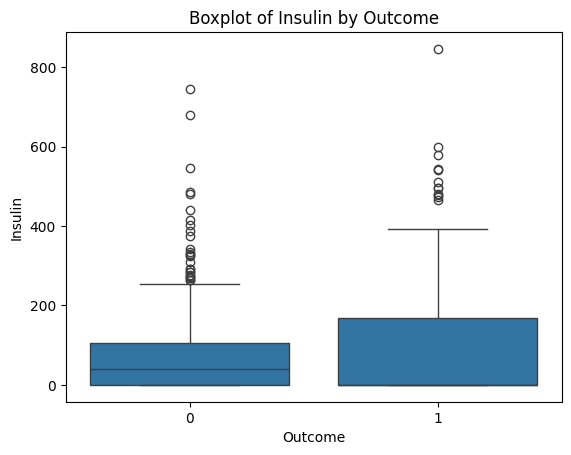

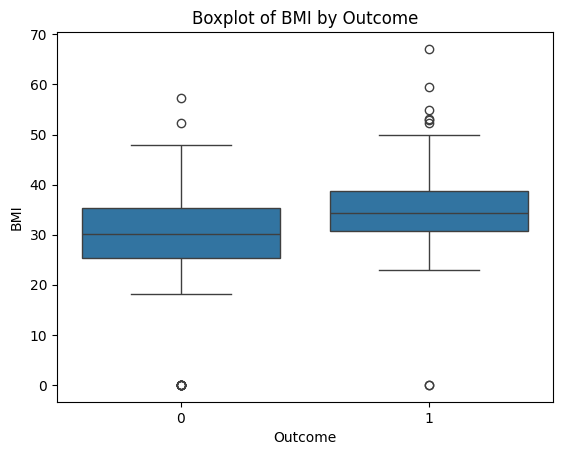

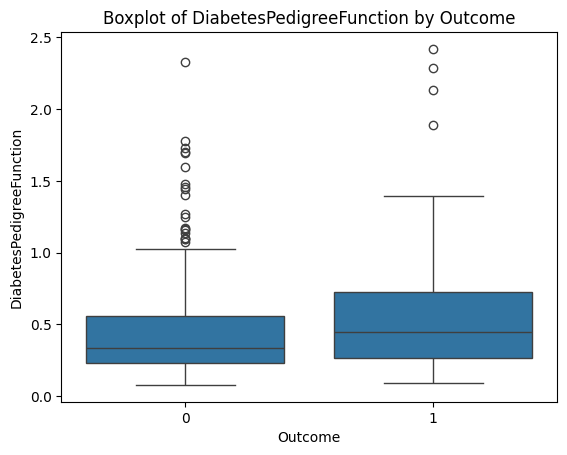

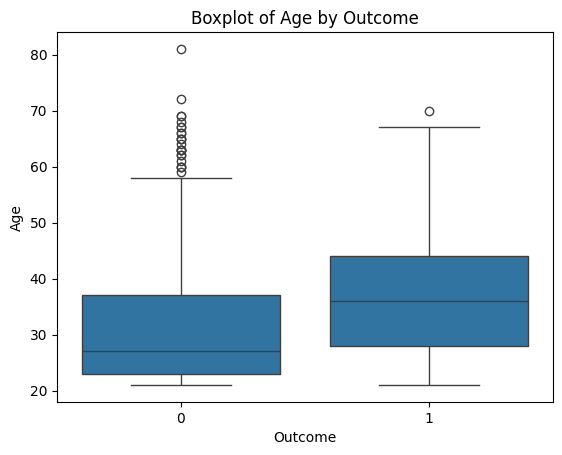

In [217]:
# Creating a boxplot for each numeric feature
features = df.columns.drop([target])
for feature in features:
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Outcome')
    plt.show()

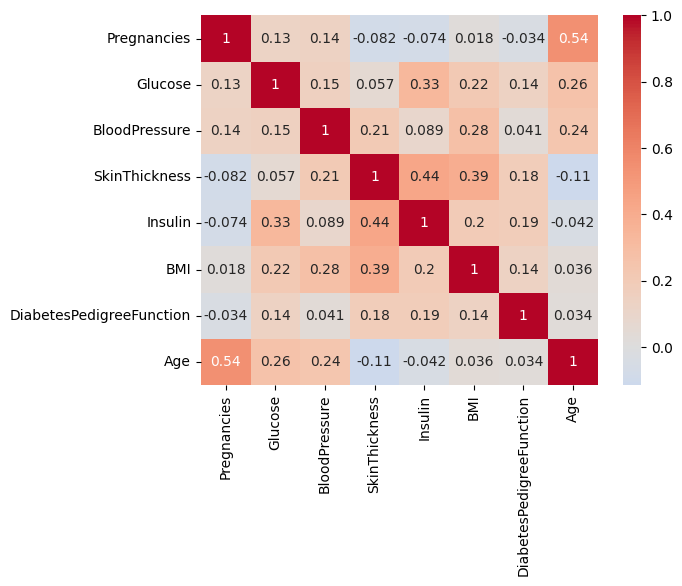

In [218]:
# Calculate correlations
corr = df[features].corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.show()

## 1.3 Dataset loading and pre-processing

In [219]:
def preprocess_dataset(df, target_variable, test_size=0.2, random_state=None):
    """
    General preprocessing pipeline for a dataset to handle missing values, encoding categorical variables, 
    and scaling numerical features.

    Parameters:
    - df: Pandas DataFrame containing the dataset.
    - target_variable: The name of the column to be used as the target variable.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.

    Returns:
    - X_train, X_test, y_train, y_test: preprocessed split data.
    """
    
    # Separate features and target variable
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    
    # Splitting the dataset into training and testing sets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Identifying numerical and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Creating transformers for numerical and categorical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combining transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Applying the ColumnTransformer to the training and testing sets
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [220]:
X_train, X_test, y_train, y_test = preprocess_dataset(df, target_variable=target, random_state=56)

# 2. Implementation

In [221]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        # Separate the data by class
        self.classes = np.unique(y)
        self.parameters = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0),
                'prior': X_c.shape[0] / X.shape[0]
            }
            
    def calculate_likelihood(self, class_idx, x):
        mean = self.parameters[class_idx]["mean"]
        var = self.parameters[class_idx]["var"]
        numerator = np.exp(-(x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def calculate_posterior(self, x):
        posteriors = []
        
        for c in self.classes:
            prior = np.log(self.parameters[c]["prior"])
            conditional_prob = np.sum(np.log(self.calculate_likelihood(c, x)))
            posteriors.append(prior + conditional_prob)
            
        return self.classes[np.argmax(posteriors)]
    
    def predict(self, X):
        return [self.calculate_posterior(x) for x in X]

# 3. Model Training

In [222]:
all_model_metrics = []

In [223]:
nb = GaussianNaiveBayes()
nb.fit(X_train, y_train)

# 4. Testing and evaluation


Classification report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       100
           1       0.62      0.52      0.57        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154



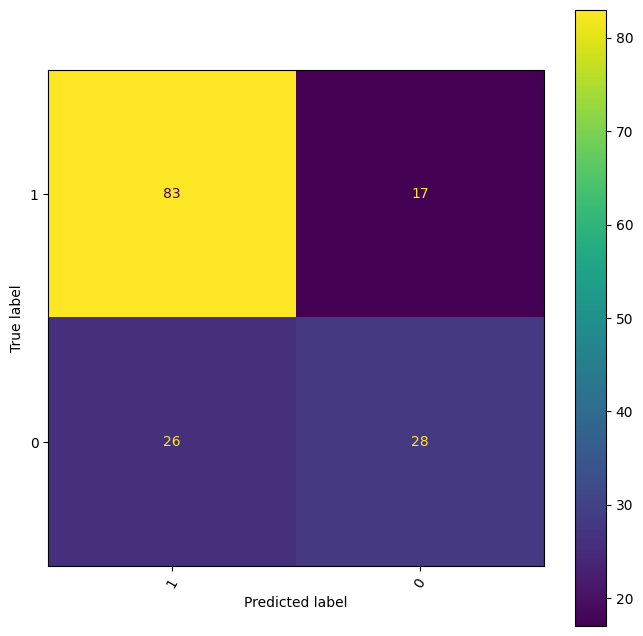

In [224]:
y_pred = nb.predict(X_test)

# Generating the classification report
class_report = classification_report(y_test, y_pred)
print('Classification report:')
print(class_report)

all_model_metrics.append({
    'model': 'Gaussian Naive Bayes',
    'classification_report': class_report
})

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation=60, ax=ax)
plt.show()

# 5. Comparison 

## 5.1 Train comparison models

In [225]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [226]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [227]:
k_nearest_neighbors = KNeighborsClassifier()
k_nearest_neighbors.fit(X_train, y_train)

KNeighborsClassifier()

In [228]:
support_vector_machine = svm.SVC()
support_vector_machine.fit(X_train, y_train)

SVC()

## 5.2 Comparison models evaluation

Logistic Regression:
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       100
           1       0.71      0.50      0.59        54

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154



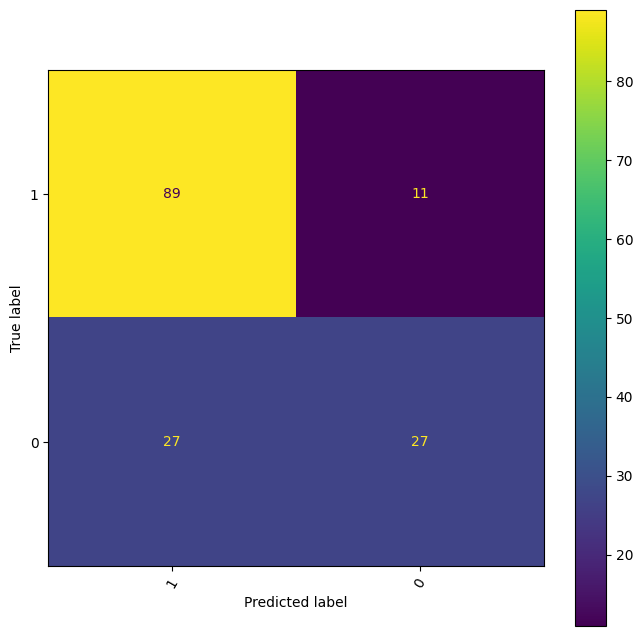

In [229]:
y_pred = logistic_regression.predict(X_test)
print('Logistic Regression:')

# Generating the classification report
class_report = classification_report(y_test, y_pred)
print('Classification report:')
print(class_report)

all_model_metrics.append({
    'model': 'Logistic Regression',
    'classification_report': class_report
})

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation=60, ax=ax)
plt.show()

Decision Tree:
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       100
           1       0.63      0.50      0.56        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154



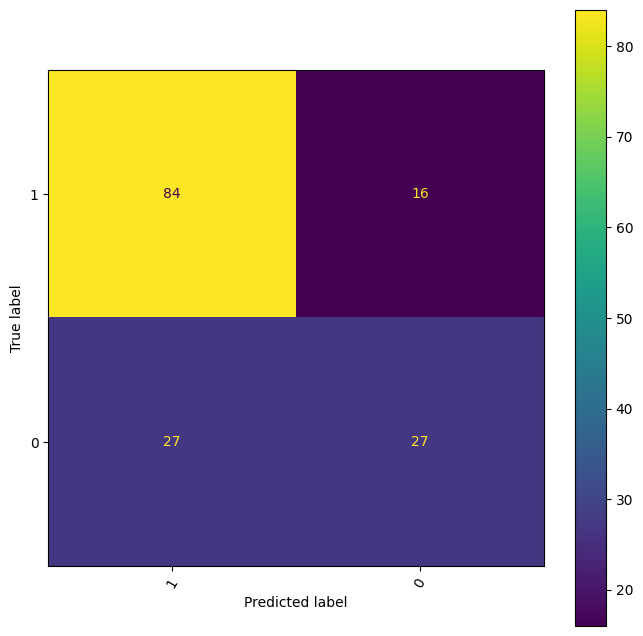

In [230]:
y_pred = decision_tree.predict(X_test)
print('Decision Tree:')

# Generating the classification report
class_report = classification_report(y_test, y_pred)
print('Classification report:')
print(class_report)

all_model_metrics.append({
    'model': 'Decision Tree',
    'classification_report': class_report
})

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation=60, ax=ax)
plt.show()

K-Nearest Neighbors:
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       100
           1       0.68      0.50      0.57        54

    accuracy                           0.74       154
   macro avg       0.72      0.69      0.69       154
weighted avg       0.73      0.74      0.73       154



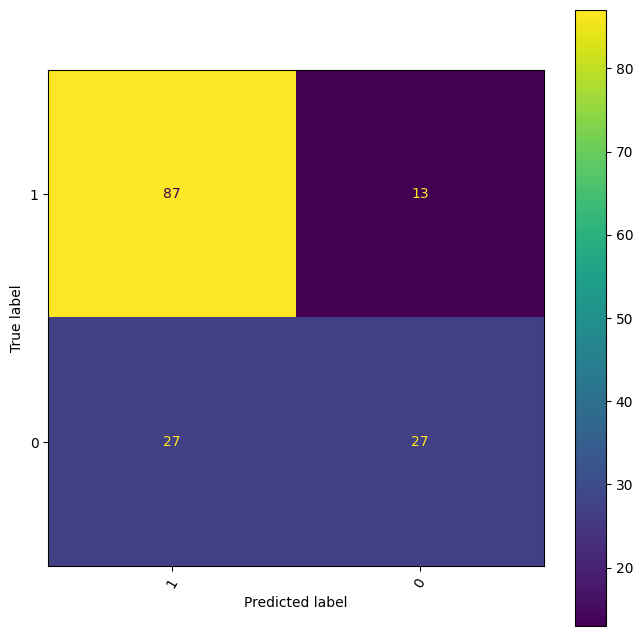

In [231]:
y_pred = k_nearest_neighbors.predict(X_test)
print('K-Nearest Neighbors:')

# Generating the classification report
class_report = classification_report(y_test, y_pred)
print('Classification report:')
print(class_report)

all_model_metrics.append({
    'model': 'K-Nearest Neighbors',
    'classification_report': class_report
})

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation=60, ax=ax)
plt.show()

Support Vector Machine:
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



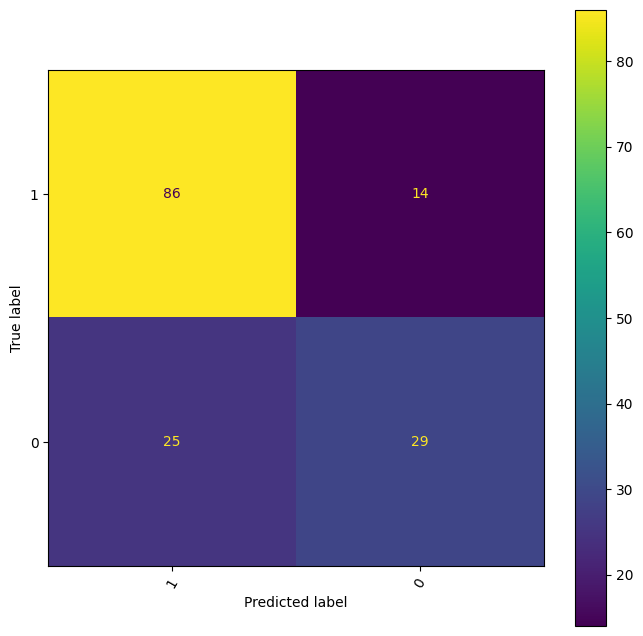

In [232]:
y_pred = support_vector_machine.predict(X_test)
print('Support Vector Machine:')

# Generating the classification report
class_report = classification_report(y_test, y_pred)
print('Classification report:')
print(class_report)

all_model_metrics.append({
    'model': 'Support Vector Machine',
    'classification_report': class_report
})

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation=60, ax=ax)
plt.show()

## 5.3 Models comparison

In [233]:
for model_report in all_model_metrics:
    print(f"Classification Report for {model_report['model']}:")
    print(model_report['classification_report'])
    print("\n" + "-"*80 + "\n")

Classification Report for Gaussian Naive Bayes:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       100
           1       0.62      0.52      0.57        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154


--------------------------------------------------------------------------------

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       100
           1       0.71      0.50      0.59        54

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154


--------------------------------------------------------------------------------

Classification Report for Decision Tree:
              precision    recall  f1-score 